In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [2]:
df1=pd.read_csv("data_casestudy.csv")

In [4]:
df1.head()

,lead_id,make,model,variant,fuel_type,owner_number,inspection_date,odometer_reading,HVB,acCoolingIsNormal_airConditioning,...,rhsFrontDoor_exteriorTyres,rhsRearDoor_exteriorTyres,totalRFC_summary,rating_accessoriesFeatures,rating_airConditioning,rating_electricalsInterior,rating_engineTransmission,rating_exteriorTyres,rating_steeringSuspensionBrakes,number_of_dealers
0,1000000199,HONDA,CIVIC,1.8V AT,Petrol,1,08-12-2017,56780,160000.0,Yes,...,Yes,Yes,39500.0,5,3,3,4,3,3,4
1,1000000494,MARUTI SUZUKI,RITZ,LXI BS IV,Petrol,2,25-01-2018,84215,130000.0,Yes,...,Yes,Yes,27500.0,5,5,4,5,2,4,4
2,1000000593,HYUNDAI,EON,MAGNA PLUS,Petrol,1,25-01-2018,34794,199000.0,Yes,...,Yes,No,28000.0,5,5,4,4,3,4,6
3,1000000794,FORD,FIGO,ZXI DURATEC 1.2,Petrol,1,24-01-2018,72326,104000.0,No,...,No,No,27200.0,5,3,3,3,3,3,3
4,1000002298,HYUNDAI,VERNA,FLUIDIC 1.6 EX CRDI,Diesel,1,16-09-2017,76961,412000.0,Yes,...,Yes,Yes,47500.0,5,5,4,3,3,4,12


## S1. DATA UNDERSTANDING AND CLEANING

### Treating Missing Values

In [5]:
# Find % of MV in each variable
p_mv_df=pd.DataFrame(df1.isnull().sum()*100/df1.shape[0]).rename(columns={0:'p_mv'})
p_mv_df.head()

,p_mv
lead_id,0.0
make,0.0
model,0.0
variant,0.0
fuel_type,0.0


In [6]:
list(filter(lambda x: x>15,p_mv_df['p_mv']))

[76.06378454996457, 69.47554925584691]

In [7]:
#remove cols with>15% MV
rem_val=list(filter(lambda x: x>15,p_mv_df['p_mv']))
rem_cols=list(pd.DataFrame(p_mv_df.loc[p_mv_df["p_mv"].isin(rem_val)]).index)
l1=list(df1.columns)
l2=rem_cols
keep_cols=[x for x in l1 if x not in l2]
keep_cols

['lead_id',
 'make',
 'model',
 'variant',
 'fuel_type',
 'owner_number',
 'inspection_date',
 'odometer_reading',
 'HVB',
 'acCoolingIsNormal_airConditioning',
 'acFanAndCompressorNoiseIsNormal_airConditioning',
 'heaterOperationIsNormalAndEffective_airConditioning',
 'interstateNocIssued_documentDetails',
 'isUnderHypothecation_documentDetails',
 'roadTaxPaidInterstate_documentDetails',
 'toBeScrapped_documentDetails',
 'allDisplayLightsIsWorkingProperly_electricalsInterior',
 'doorFunctionsProperly_electricalsInterior',
 'musicSystemWorksFine_electricalsInterior',
 'powerWindowWorkingProperly_electricalsInterior',
 'batteryPerformanceSatisfactory_engineTransmission',
 'clutchOperatesSmoothlyWithoutSlipping_engineTransmission',
 'coolant_engineTransmission',
 'engineExcessiveBlowByOrBack_engineTransmission',
 'engineExhaustSmoke_engineTransmission',
 'engineOil_engineTransmission',
 'engineSoundIsNormal_engineTransmission',
 'gearShiftingWorksProperly_engineTransmission',
 'bonnet_ex

In [8]:
df2=df1[keep_cols]
p_mv=df2.isnull().sum()*100/df1.shape[0]
p_mv
# good to go! no more columns with>15% MV

lead_id                                                      0.000000
make                                                         0.000000
model                                                        0.000000
variant                                                      0.000000
fuel_type                                                    0.000000
owner_number                                                 0.000000
inspection_date                                              0.000000
odometer_reading                                             0.000000
HVB                                                          0.000000
acCoolingIsNormal_airConditioning                            0.612332
acFanAndCompressorNoiseIsNormal_airConditioning              0.609497
heaterOperationIsNormalAndEffective_airConditioning          0.962438
interstateNocIssued_documentDetails                          0.000000
isUnderHypothecation_documentDetails                         0.000000
roadTaxPaidInterstat

In [9]:
list(filter(lambda x: x>0,p_mv))

[0.6123316796598157,
 0.6094968107725017,
 0.96243798724309,
 4.165839829907867,
 10.834868887313961,
 2.1148121899362153]

In [10]:
# find cols with MV for imputation
mv_vals=list(filter(lambda x: x>0,p_mv))
mv_cols=list(pd.DataFrame(p_mv_df.loc[p_mv_df["p_mv"].isin(mv_vals)]).index)
df_temp=df2[mv_cols]
df_temp.head()

,acCoolingIsNormal_airConditioning,acFanAndCompressorNoiseIsNormal_airConditioning,heaterOperationIsNormalAndEffective_airConditioning,musicSystemWorksFine_electricalsInterior,powerWindowWorkingProperly_electricalsInterior,clutchOperatesSmoothlyWithoutSlipping_engineTransmission
0,Yes,No,Yes,Yes,Yes,NaN
1,Yes,Yes,Yes,Yes,Yes,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes
3,No,Yes,Yes,Yes,Yes,Yes
4,Yes,Yes,Yes,Yes,Yes,No


In [11]:
# since all MV cols are categorical, impute them with their modes
df3=df2
df3.apply(lambda x:x.fillna(x.value_counts().index[0]))
df3

,lead_id,make,model,variant,fuel_type,owner_number,inspection_date,odometer_reading,HVB,acCoolingIsNormal_airConditioning,...,rhsFrontDoor_exteriorTyres,rhsRearDoor_exteriorTyres,totalRFC_summary,rating_accessoriesFeatures,rating_airConditioning,rating_electricalsInterior,rating_engineTransmission,rating_exteriorTyres,rating_steeringSuspensionBrakes,number_of_dealers
0,1000000199,HONDA,CIVIC,1.8V AT,Petrol,1,08-12-2017,56780,160000.0,Yes,...,Yes,Yes,39500.0,5,3,3,4,3,3,4
1,1000000494,MARUTI SUZUKI,RITZ,LXI BS IV,Petrol,2,25-01-2018,84215,130000.0,Yes,...,Yes,Yes,27500.0,5,5,4,5,2,4,4
2,1000000593,HYUNDAI,EON,MAGNA PLUS,Petrol,1,25-01-2018,34794,199000.0,Yes,...,Yes,No,28000.0,5,5,4,4,3,4,6
3,1000000794,FORD,FIGO,ZXI DURATEC 1.2,Petrol,1,24-01-2018,72326,104000.0,No,...,No,No,27200.0,5,3,3,3,3,3,3
4,1000002298,HYUNDAI,VERNA,FLUIDIC 1.6 EX CRDI,Diesel,1,16-09-2017,76961,412000.0,Yes,...,Yes,Yes,47500.0,5,5,4,3,3,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70545,1129963695,MARUTI SUZUKI,ALTO,K10 VXI,Petrol,1,04-06-2017,30232,214000.0,No,...,Yes,Yes,23000.0,5,4,4,4,3,4,7
70546,1129964191,TOYOTA,FORTUNER,3.0 MT 4X4,Diesel,2,16-10-2017,150209,751750.0,No,...,Yes,Yes,68000.0,5,3,3,3,3,3,2
70547,1129972593,MARUTI SUZUKI,SWIFT,ZXI,Petrol,1,20-08-2017,7524,495000.0,Yes,...,Yes,Yes,25000.0,5,5,5,5,3,5,6
70548,1129973395,TOYOTA,FORTUNER,3.0 MT 4X4,Diesel,1,10-08-2017,130069,850000.0,No,...,Yes,Yes,71000.0,4,4,4,3,3,4,8


### Check if Dependent Variable is Normally Distributed

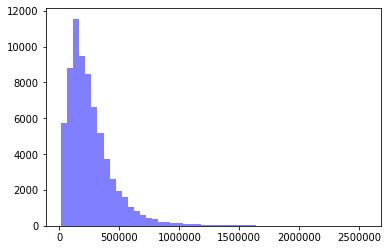

In [12]:
#calculating a decent size for bins 
(df1["HVB"].max()-df1["HVB"].min())/50
plt.hist(df1['HVB'], 50, facecolor='blue', alpha=0.5)
plt.show()

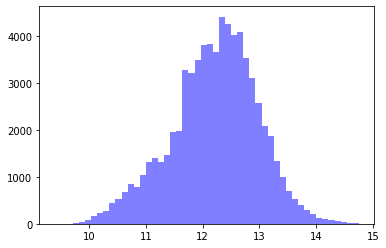

In [13]:
# doesn't look normal, so try log transformation
log_HVB=np.log(df1['HVB'])
plt.hist(log_HVB, 50, facecolor='blue', alpha=0.5)
plt.show()
# looks pretty normal, good to go!

### Removing Highly Correlated Variables

In [14]:
# correlation matrix for numerical variables
corr_mat=df3.corr()
corr_mat

,lead_id,owner_number,odometer_reading,HVB,totalRFC_summary,rating_accessoriesFeatures,rating_airConditioning,rating_electricalsInterior,rating_engineTransmission,rating_exteriorTyres,rating_steeringSuspensionBrakes,number_of_dealers
lead_id,1.000000,0.005125,0.011177,0.031746,0.095712,-0.005392,0.034290,0.070229,-0.016170,0.049644,-0.032991,-0.048114
owner_number,0.005125,1.000000,0.124668,-0.194030,0.131504,-0.071089,-0.130125,-0.110789,-0.130461,-0.128978,-0.155545,-0.117353
odometer_reading,0.011177,0.124668,1.000000,-0.100734,0.387288,-0.130227,-0.154952,-0.269883,-0.339539,-0.219558,-0.321441,-0.150555
HVB,0.031746,-0.194030,-0.100734,1.000000,-0.014097,0.108124,0.253568,0.255564,0.302877,0.195028,0.340228,0.224976
totalRFC_summary,0.095712,0.131504,0.387288,-0.014097,1.000000,-0.200994,-0.308719,-0.394693,-0.494021,-0.238063,-0.456613,-0.233838
rating_accessoriesFeatures,-0.005392,-0.071089,-0.130227,0.108124,-0.200994,1.000000,0.220912,0.213872,0.180962,0.069038,0.202495,0.104981
rating_airConditioning,0.034290,-0.130125,-0.154952,0.253568,-0.308719,0.220912,1.000000,0.318222,0.301849,0.146573,0.310225,0.192796
rating_electricalsInterior,0.070229,-0.110789,-0.269883,0.255564,-0.394693,0.213872,0.318222,1.000000,0.450057,0.261286,0.431858,0.219202
rating_engineTransmission,-0.016170,-0.130461,-0.339539,0.302877,-0.494021,0.180962,0.301849,0.450057,1.000000,0.297183,0.537193,0.253634
rating_exteriorTyres,0.049644,-0.128978,-0.219558,0.195028,-0.238063,0.069038,0.146573,0.261286,0.297183,1.000000,0.266612,0.121443


In [15]:
for i in corr_mat:
    col=corr_mat[i]
    print('\033[1m' + i.center(50) +'\033[0m')
    for j in col:
        if abs(j)>0.8:
            print(corr_mat.loc[corr_mat[i]==j,i],'\n')
# since none of the variables are highly correlated with each other, we can't remove any on the basis of multicollinearity

                     lead_id                      
lead_id    1.0
Name: lead_id, dtype: float64 

                   owner_number                   
owner_number    1.0
Name: owner_number, dtype: float64 

                 odometer_reading                 
odometer_reading    1.0
Name: odometer_reading, dtype: float64 

                       HVB                        
HVB    1.0
Name: HVB, dtype: float64 

                 totalRFC_summary                 
totalRFC_summary    1.0
Name: totalRFC_summary, dtype: float64 

            rating_accessoriesFeatures            
rating_accessoriesFeatures    1.0
Name: rating_accessoriesFeatures, dtype: float64 

              rating_airConditioning              
rating_airConditioning    1.0
Name: rating_airConditioning, dtype: float64 

            rating_electricalsInterior            
rating_electricalsInterior    1.0
Name: rating_electricalsInterior, dtype: float64 

            rating_engineTransmission             
rating_engineTransmis

### Removing Numeric Variables that don't Have a High Correlation with HVB

In [16]:
corr_mat1=corr_mat.reset_index().rename(columns={'index':'var'})
low_corr_num=[]
for i in corr_mat1['HVB']:
    df5=pd.DataFrame(corr_mat1.loc[corr_mat1['HVB']==i,('var')])
    if abs(i)<0.2:
        low_corr_num.append(df5['var'].values[0])
print(low_corr_num)

['lead_id', 'owner_number', 'odometer_reading', 'totalRFC_summary', 'rating_accessoriesFeatures', 'rating_exteriorTyres']


In [17]:
num_df=df3._get_numeric_data()
high_corr_num=num_df.columns.drop(low_corr_num)
high_corr_num=list(set(high_corr_num))
high_corr_num

['number_of_dealers',
 'HVB',
 'rating_steeringSuspensionBrakes',
 'rating_electricalsInterior',
 'rating_airConditioning',
 'rating_engineTransmission']

### Removing Categorical Variables that Don't Vary Much

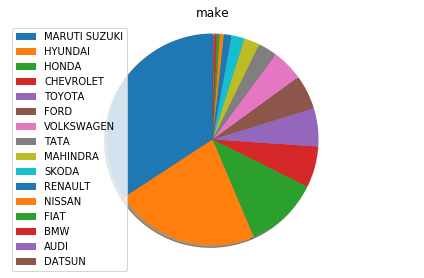

C:\Users\ankar.yadav\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


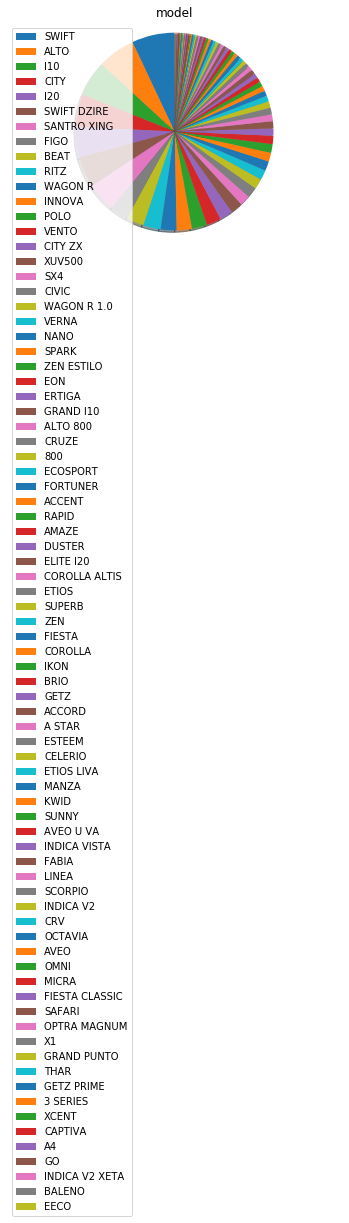

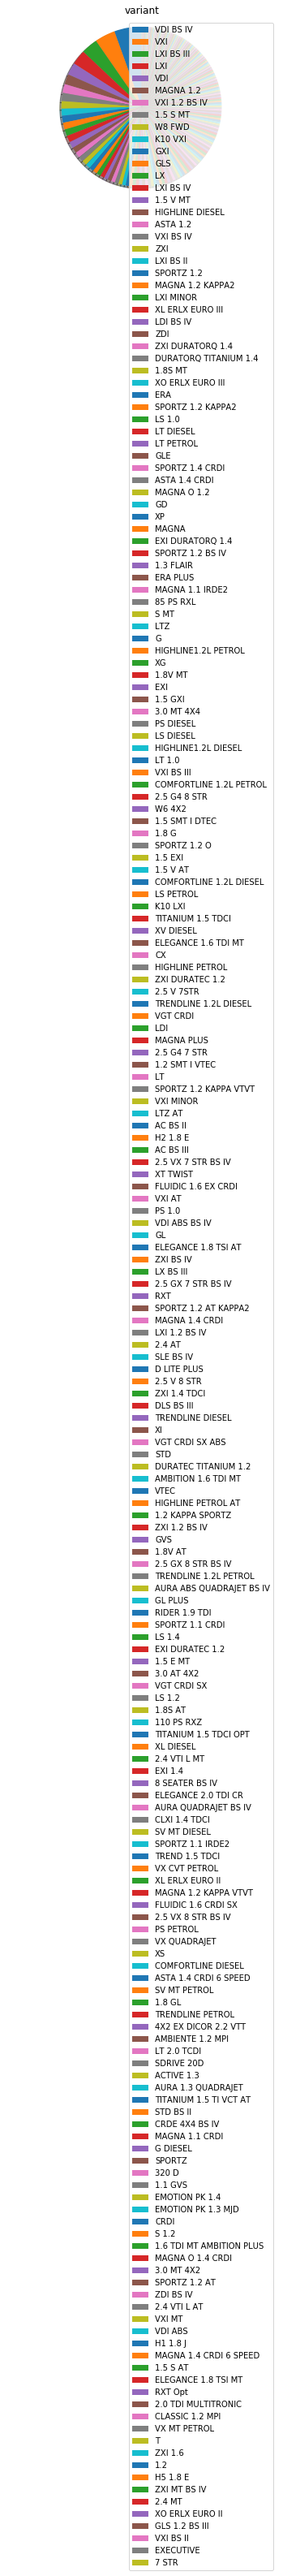

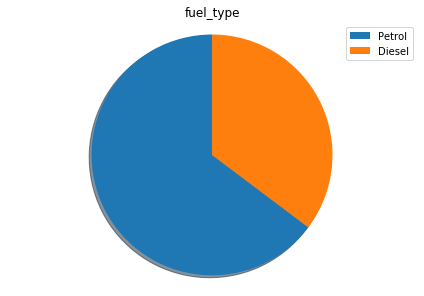

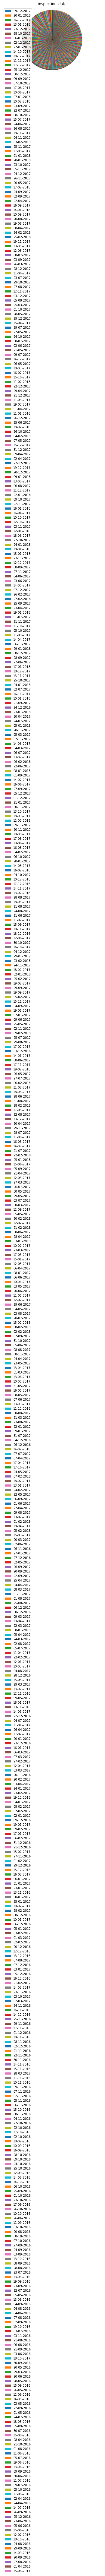

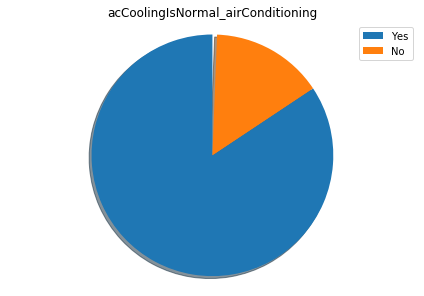

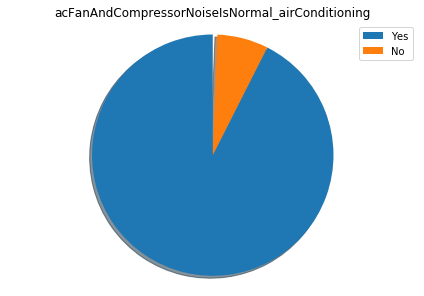

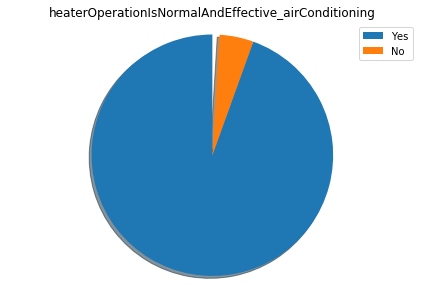

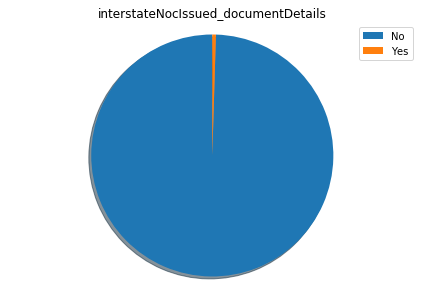

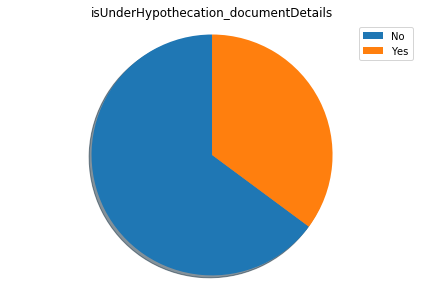

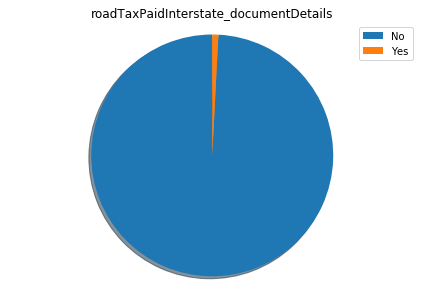

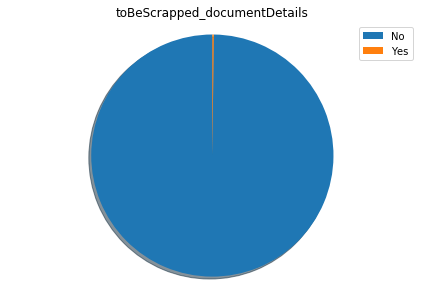

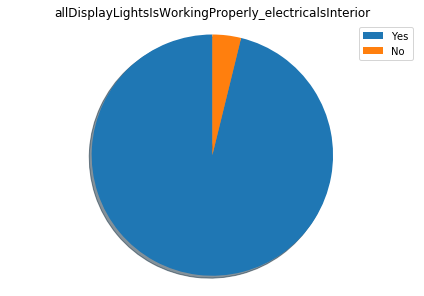

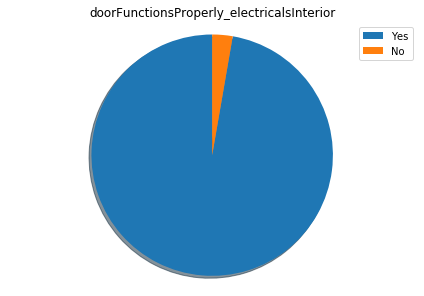

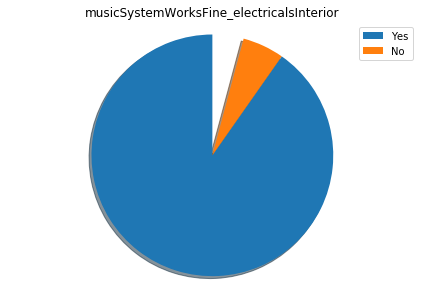

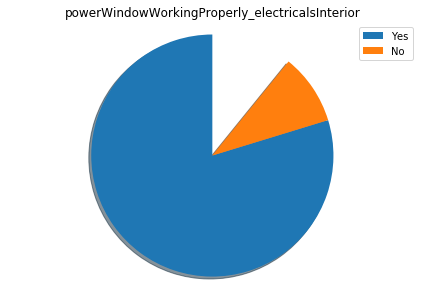

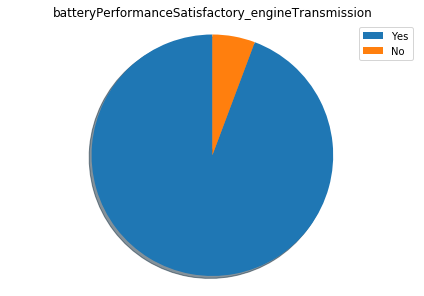

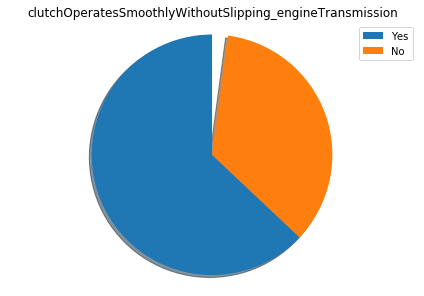

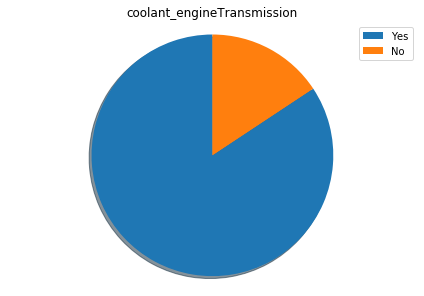

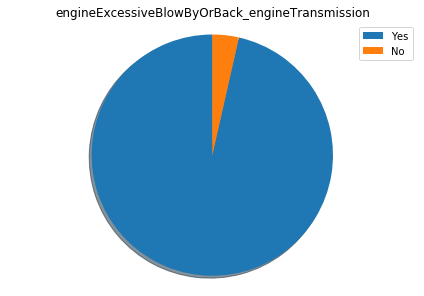

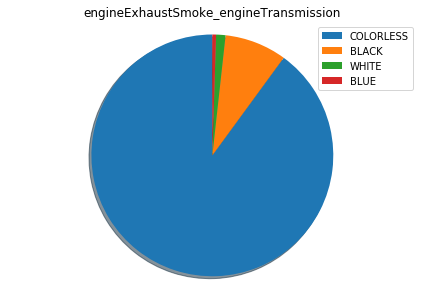

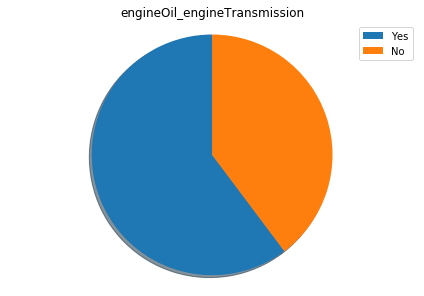

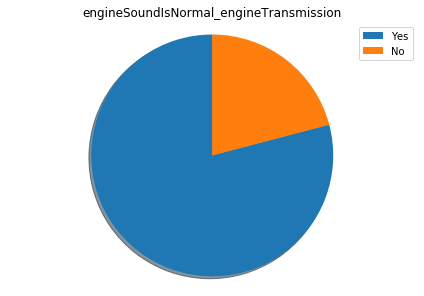

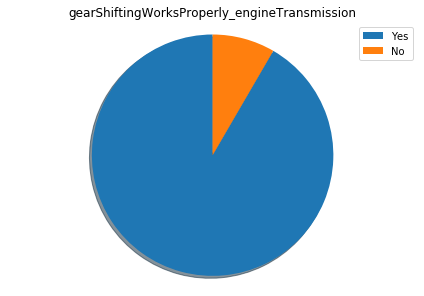

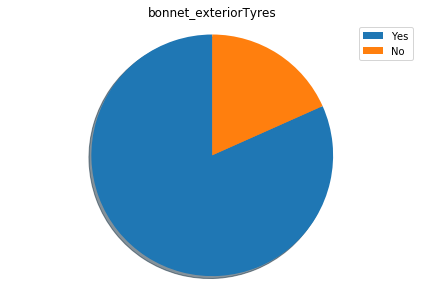

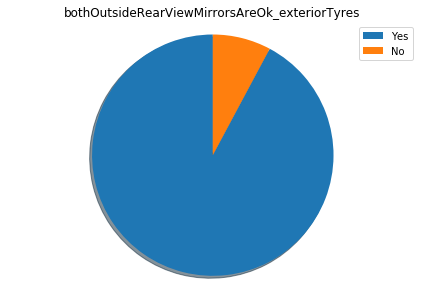

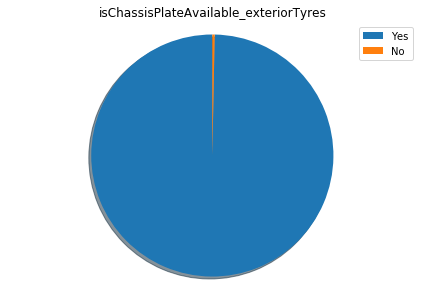

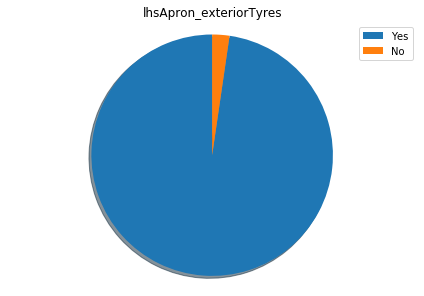

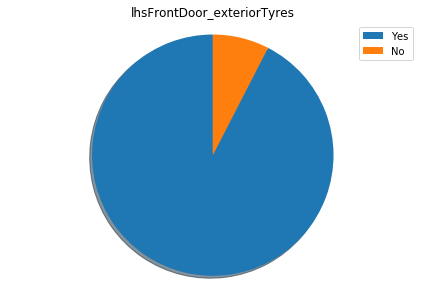

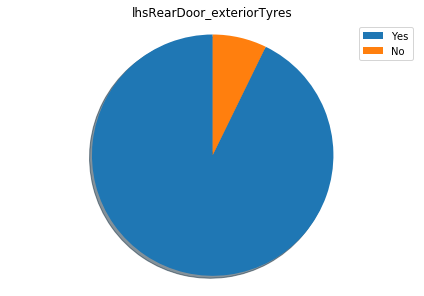

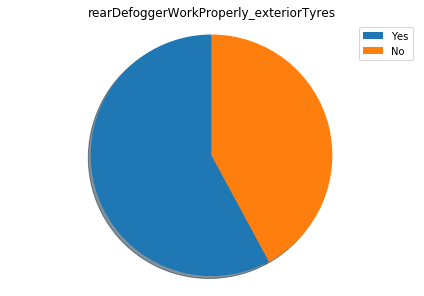

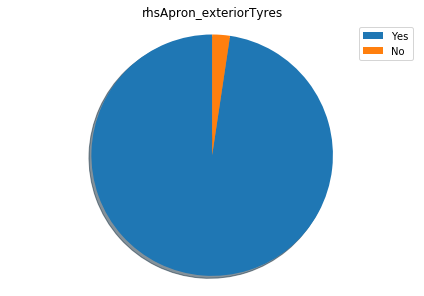

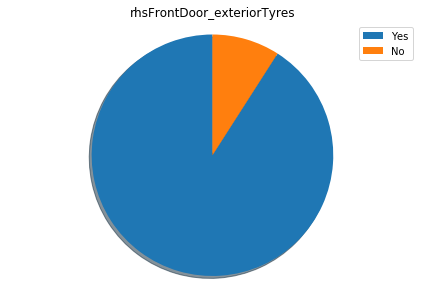

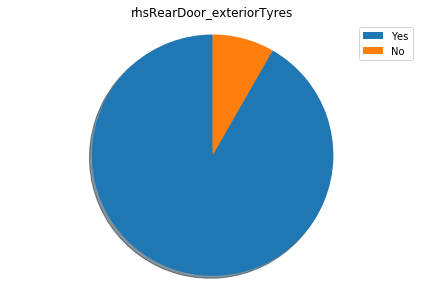

In [18]:
cat_df=df3.drop(num_df.columns,axis=1)
col=[]
freq=[]
for i in cat_df:
    col=i
    df4=pd.DataFrame(cat_df[i].value_counts()/len(cat_df[i])).reset_index().rename(columns={'index':i,i:'freq'})
    labels=df4.iloc[:,0]
    sizes=df4.iloc[:,1]
    patches, texts = plt.pie(sizes, shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title(i)
    plt.show()
# clearly, there are a lot of categorical variables with low variance which we can discard

In [19]:
low_var_cat=[]
for i in cat_df:
    col=i
    df4=pd.DataFrame(cat_df[i].value_counts()/len(cat_df[i])).reset_index().rename(columns={'index':i,i:'freq'})
    for j in df4['freq']:
        if j>=0.7:
            low_var_cat.append(i)
print(low_var_cat)

['acCoolingIsNormal_airConditioning', 'acFanAndCompressorNoiseIsNormal_airConditioning', 'heaterOperationIsNormalAndEffective_airConditioning', 'interstateNocIssued_documentDetails', 'roadTaxPaidInterstate_documentDetails', 'toBeScrapped_documentDetails', 'allDisplayLightsIsWorkingProperly_electricalsInterior', 'doorFunctionsProperly_electricalsInterior', 'musicSystemWorksFine_electricalsInterior', 'powerWindowWorkingProperly_electricalsInterior', 'batteryPerformanceSatisfactory_engineTransmission', 'coolant_engineTransmission', 'engineExcessiveBlowByOrBack_engineTransmission', 'engineExhaustSmoke_engineTransmission', 'engineSoundIsNormal_engineTransmission', 'gearShiftingWorksProperly_engineTransmission', 'bonnet_exteriorTyres', 'bothOutsideRearViewMirrorsAreOk_exteriorTyres', 'isChassisPlateAvailable_exteriorTyres', 'lhsApron_exteriorTyres', 'lhsFrontDoor_exteriorTyres', 'lhsRearDoor_exteriorTyres', 'rhsApron_exteriorTyres', 'rhsFrontDoor_exteriorTyres', 'rhsRearDoor_exteriorTyres']


In [20]:
num_df=df3._get_numeric_data()
cat_df=df3.drop(num_df.columns,axis=1)
high_var_cat=cat_df.columns.drop(low_var_cat)
high_var_cat=list(set(high_var_cat))
# logic dictates that inspection_date won't have an effect on HVB, so we can discard that as well
high_var_cat.remove('inspection_date')
high_var_cat

['make',
 'isUnderHypothecation_documentDetails',
 'model',
 'fuel_type',
 'rearDefoggerWorkProperly_exteriorTyres',
 'engineOil_engineTransmission',
 'clutchOperatesSmoothlyWithoutSlipping_engineTransmission',
 'variant']

In [21]:
final=[]
final=high_corr_num
final.extend(high_var_cat)
final=list(set(final))
final

['make',
 'isUnderHypothecation_documentDetails',
 'model',
 'number_of_dealers',
 'fuel_type',
 'HVB',
 'rating_steeringSuspensionBrakes',
 'rearDefoggerWorkProperly_exteriorTyres',
 'engineOil_engineTransmission',
 'rating_electricalsInterior',
 'rating_airConditioning',
 'clutchOperatesSmoothlyWithoutSlipping_engineTransmission',
 'rating_engineTransmission',
 'variant']

In [22]:
df6=df3.loc[:,final]
df6.head()

,make,isUnderHypothecation_documentDetails,model,number_of_dealers,fuel_type,HVB,rating_steeringSuspensionBrakes,rearDefoggerWorkProperly_exteriorTyres,engineOil_engineTransmission,rating_electricalsInterior,rating_airConditioning,clutchOperatesSmoothlyWithoutSlipping_engineTransmission,rating_engineTransmission,variant
0,HONDA,Yes,CIVIC,4,Petrol,160000.0,3,Yes,No,3,3,NaN,4,1.8V AT
1,MARUTI SUZUKI,No,RITZ,4,Petrol,130000.0,4,No,Yes,4,5,Yes,5,LXI BS IV
2,HYUNDAI,No,EON,6,Petrol,199000.0,4,No,No,4,5,Yes,4,MAGNA PLUS
3,FORD,Yes,FIGO,3,Petrol,104000.0,3,Yes,Yes,3,3,Yes,3,ZXI DURATEC 1.2
4,HYUNDAI,Yes,VERNA,12,Diesel,412000.0,4,Yes,Yes,4,5,No,3,FLUIDIC 1.6 EX CRDI


In [23]:
df7=pd.concat([df6,log_HVB],axis=1)
df7.columns.values[-1]='log_HVB'
df7.head()

,make,isUnderHypothecation_documentDetails,model,number_of_dealers,fuel_type,HVB,rating_steeringSuspensionBrakes,rearDefoggerWorkProperly_exteriorTyres,engineOil_engineTransmission,rating_electricalsInterior,rating_airConditioning,clutchOperatesSmoothlyWithoutSlipping_engineTransmission,rating_engineTransmission,variant,log_HVB
0,HONDA,Yes,CIVIC,4,Petrol,160000.0,3,Yes,No,3,3,NaN,4,1.8V AT,11.982929
1,MARUTI SUZUKI,No,RITZ,4,Petrol,130000.0,4,No,Yes,4,5,Yes,5,LXI BS IV,11.775290
2,HYUNDAI,No,EON,6,Petrol,199000.0,4,No,No,4,5,Yes,4,MAGNA PLUS,12.201060
3,FORD,Yes,FIGO,3,Petrol,104000.0,3,Yes,Yes,3,3,Yes,3,ZXI DURATEC 1.2,11.552146
4,HYUNDAI,Yes,VERNA,12,Diesel,412000.0,4,Yes,Yes,4,5,No,3,FLUIDIC 1.6 EX CRDI,12.928779


In [24]:
dep_df=df6.iloc[:,1:]
dep_cols=dep_df.columns
dep_df.head()

,isUnderHypothecation_documentDetails,model,number_of_dealers,fuel_type,HVB,rating_steeringSuspensionBrakes,rearDefoggerWorkProperly_exteriorTyres,engineOil_engineTransmission,rating_electricalsInterior,rating_airConditioning,clutchOperatesSmoothlyWithoutSlipping_engineTransmission,rating_engineTransmission,variant
0,Yes,CIVIC,4,Petrol,160000.0,3,Yes,No,3,3,NaN,4,1.8V AT
1,No,RITZ,4,Petrol,130000.0,4,No,Yes,4,5,Yes,5,LXI BS IV
2,No,EON,6,Petrol,199000.0,4,No,No,4,5,Yes,4,MAGNA PLUS
3,Yes,FIGO,3,Petrol,104000.0,3,Yes,Yes,3,3,Yes,3,ZXI DURATEC 1.2
4,Yes,VERNA,12,Diesel,412000.0,4,Yes,Yes,4,5,No,3,FLUIDIC 1.6 EX CRDI


In [25]:
dumm_df=pd.get_dummies(dep_df,drop_first=True)
dumm_df.head()

,number_of_dealers,HVB,rating_steeringSuspensionBrakes,rating_electricalsInterior,rating_airConditioning,rating_engineTransmission,isUnderHypothecation_documentDetails_Yes,model_800,model_A STAR,model_A4,...,variant_ZDI,variant_ZDI BS IV,variant_ZXI,variant_ZXI 1.2 BS IV,variant_ZXI 1.4 TDCI,variant_ZXI 1.6,variant_ZXI BS IV,variant_ZXI DURATEC 1.2,variant_ZXI DURATORQ 1.4,variant_ZXI MT BS IV
0,4,160000.0,3,3,3,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,130000.0,4,4,5,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,199000.0,4,4,5,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,104000.0,3,3,3,3,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,12,412000.0,4,4,5,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check for Outliers

In [26]:
num_df=df7._get_numeric_data()
num_cols=list(num_df.columns)
num_cols

['number_of_dealers',
 'HVB',
 'rating_steeringSuspensionBrakes',
 'rating_electricalsInterior',
 'rating_airConditioning',
 'rating_engineTransmission',
 'log_HVB']

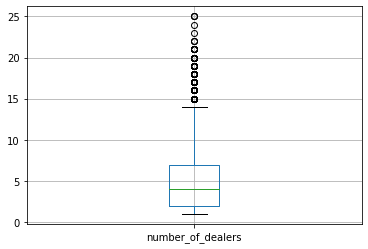

1
14


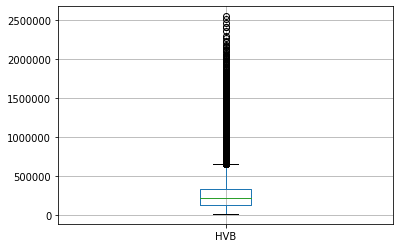

12000.0
651000.0


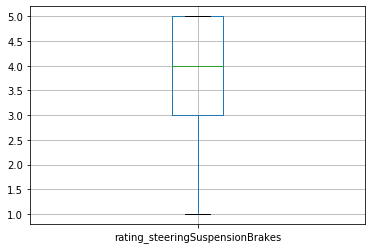

1
5


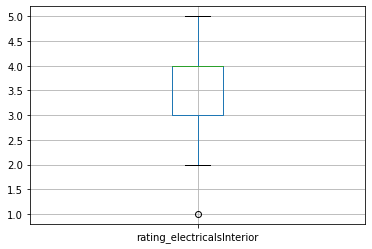

2
5


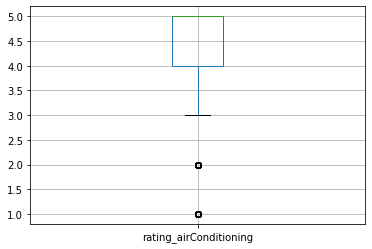

3
5


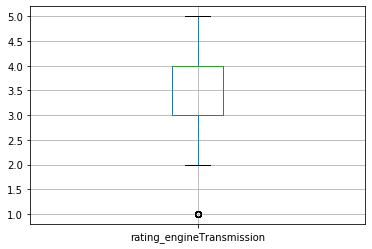

2
5


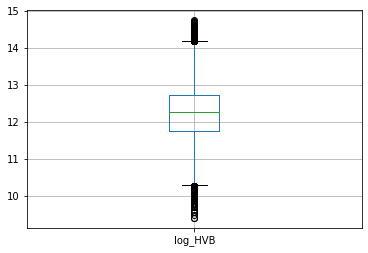

10.275051108968611
14.19394699368452


In [27]:
# for i in num_cols:
#     num_df.boxplot(column=[i])
#     plt.show()
#     plt.close()
for i in num_cols:
    num_df.boxplot(column=[i])
    plt.show()
    plt.close()
    q1=np.percentile(num_df[i],25)
    q3=np.percentile(num_df[i],75)
    iqr=q3-q1
    x=[]
    y=[]
    for j in num_df[i]:
        if j>=q1-1.5*iqr:
            x.append(j)
    print(min(x))
    for j in num_df[i]:
        if j<=q3+1.5*iqr:
            y.append(j)
    print(max(y))

In [28]:
num_df1=num_df.copy(deep=True)
# num_df1['lower_whisker']=np.nan
# num_df1['upper_whisker']=np.nan

# ind=0
for i in num_cols:
#     num_df.boxplot(column=[i])
#     plt.show()
#     plt.close()
    q1=np.percentile(num_df1[i],25)
    q3=np.percentile(num_df1[i],75)
    iqr=q3-q1
    x=[]
    y=[]
    for j in num_df1[i]:
        if j>=q1-1.5*iqr:
            x.append(j)
#     print(min(x))
#     print(ind)-
    
#     print(min(x))
#     for j in num_df1[i]:
        if j<=q1+1.5*iqr:
            y.append(j)
    num_df1.loc[:,'lower_whisker'+'_'+i]=min(x)
    num_df1.loc[:,'upper_whisker'+'_'+i]=max(y)
#     print(max(x))
#     ind+=1


## Model

In [29]:
df8=df7.drop(['HVB'],axis=1)
num_df1=df8._get_numeric_data()
cat_df1=df8.drop(num_df1.columns,axis=1)
dumm_df1=pd.get_dummies(cat_df1,drop_first=True)
df9=pd.concat([num_df1,dumm_df1],axis=1)
df9.head()
# df3._get_numeric_data()

,number_of_dealers,rating_steeringSuspensionBrakes,rating_electricalsInterior,rating_airConditioning,rating_engineTransmission,log_HVB,make_BMW,make_CHEVROLET,make_DATSUN,make_FIAT,...,variant_ZDI,variant_ZDI BS IV,variant_ZXI,variant_ZXI 1.2 BS IV,variant_ZXI 1.4 TDCI,variant_ZXI 1.6,variant_ZXI BS IV,variant_ZXI DURATEC 1.2,variant_ZXI DURATORQ 1.4,variant_ZXI MT BS IV
0,4,3,3,3,4,11.982929,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,4,5,5,11.775290,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,4,4,5,4,12.201060,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,3,3,11.552146,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,12,4,4,5,3,12.928779,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# dividing into test and train data
random.seed(7)
# X_train,X_test,y_train,y_test=train_test_split(df7,log_HVB,test_size=0.30)
divide=train_test_split(df9,test_size=0.30)
df_train=divide[0]
df_test=divide[1]

X_test=df_test.drop(['log_HVB'],axis=1)
y_test=df_test['log_HVB'].reset_index()['log_HVB']
y_train=df_train['log_HVB']
X_train=df_train.drop(['log_HVB'],axis=1)

In [31]:
# fitting into model
lm=linear_model.LinearRegression()
model=lm.fit(X_train,y_train)
predicted=lm.predict(X_test)

y_pred=pd.Series(predicted)
table=pd.concat([y_pred, y_test],axis=1)
table.rename(columns={0:"y_pred","log_HVB":"y_test"},inplace=True)
table['error']=abs(table['y_test']-table["y_pred"])

In [32]:
# calculating summary statistics
root_mse = mean_squared_error(table['y_pred'],table['y_test'])**0.5
MAPE = 100*(abs(table['y_pred']-table["y_test"])/table["y_test"]).mean()
r_squared = lm.score(X_test,y_test)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print ('Adjusted r squared:%.2f' % adjusted_r_squared)
print("Mean squared error: %.2f" % root_mse)
print('MAPE: %.2f' % MAPE)

# high adjusted r^2 and low MSE and MAPE is good news!

Adjusted r squared:0.88
Mean squared error: 0.26
MAPE: 1.70


## S3. Checking Assumptions

### Multicollinearity

In [33]:
X = num_df1
# X.drop(['owner_number','HVB','rating_accessoriesFeatures','rating_airConditioning','rating_electricalsInterior','rating_engineTransmission','rating_exteriorTyres','rating_steeringSuspensionBrakes'],axis=1,inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

# VIF is high but this shouldn't be a problem as long as only prediction is our objective

,VIF Factor,features
0,3.768841,number_of_dealers
1,35.111616,rating_steeringSuspensionBrakes
2,43.064213,rating_electricalsInterior
3,45.938361,rating_airConditioning
4,34.878673,rating_engineTransmission
5,68.434552,log_HVB


### Normality

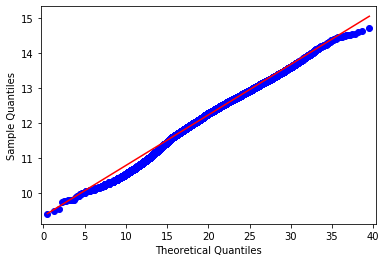

In [34]:
#QQ-plot
sm.qqplot(y_test, loc = 20, scale = 5,  line='q')
pylab.show()

# looks fairly normal

### Autocorrelation

In [35]:
model1=sm.OLS(y_train,X_train)
result=model1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_HVB   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1538.
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:06:18   Log-Likelihood:                -3472.7
No. Observations:               49385   AIC:                             7427.
Df Residuals:                   49144   BIC:                             9550.
Df Model:                         240                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
number_of_dealers                                                0.0228      0.000     57.159      0.000       0.022       0.024
rating_steeringSuspensionBrakes                                  0.0589      0.002     32.835      0.000       0.055       0.062
rating_electricalsInterior                                       0.0720      0.002     36.776      0.000       0.068       0.076
rating_airConditioning                                           0.0582      0.002     33.777      0.000       0.055       0.062
rating_engineTransmission                                        0.0419      0.002     20.353      0.000       0.038       0.046
make_BMW                                                         7.5133      0.015    503.066      0.000       7.484       7.543
make_CHEVROLET                                                   9.0490      0.044    203.437      0.000       8.962       9.136
make_DATSUN                                                      3.8529      0.036    108.504      0.000       3.783       3.923
make_FIAT                                                        5.9401      0.019    313.259      0.000       5.903       5.977
make_FORD                                                        8.6711      0.039    225.012      0.000       8.596       8.747
make_HONDA                                                       9.7640      0.078    125.595      0.000       9.612       9.916
make_HYUNDAI                                                    10.2450      0.072    142.771      0.000      10.104      10.386
make_MAHINDRA                                                    7.5319      0.010    774.355      0.000       7.513       7.551
make_MARUTI SUZUKI                                              10.3385      0.073    141.136      0.000      10.195      10.482
make_NISSAN                                                      5.6286      0.010    543.896      0.000       5.608       5.649
make_RENAULT                                                     6.7920      0.030    223.660      0.000       6.732       6.852
make_SKODA                                                       8.3795      0.034    249.131      0.000       8.314       8.445
make_TATA                                                        8.3935      0.028    303.311      0.000       8.339       8.448
make_TOYOTA                                                      9.6068      0.036    268.873      0.000       9.537       9.677
make_VOLKSWAGEN                                                  7.3952      0.033    225.320      0.000       7.331       7.460
isUnderHypothecation_documentDetails_Yes                         0.0513      0.003     20.060      0.000       0.046

In [36]:
durbin_watson(result.resid)

# Durbin-Watson statistic will always have a value between 0 and 4
# a value of 2.0 means that there is no autocorrelation detected in the sample -> great! means we haven't omitted any 
# impt vars

1.9948558513917698

### Heteroscedasticity

In [46]:
import statsmodels as sms

In [47]:
name=['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
test=sms.stats.diagnostic.het_breuschpagan(result.resid, result.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4866.941685387808),
 ('p-value', 0.0),
 ('f-value', 22.38613864816292),
 ('f p-value', 0.0)]

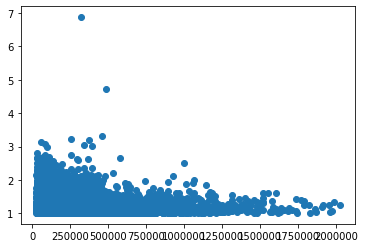

In [48]:
plt.scatter(np.exp(table['y_pred']),np.exp(table['error']))
plt.show()

# no fanning as X increases => no cause for concern